In [ ]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import Independent, Normal

from MAGPS.data import Collector, VectorReplayBuffer
from MAGPS.env import DummyVectorEnv
from MAGPS.policy.MARL_base import MARL_BasePolicy
from MAGPS.trainer import OnpolicyTrainer
from MAGPS.utils import TensorboardLogger
from MAGPS.policy.gym_marl_policy.ippo import IPPOPolicy
from MAGPS.utils.net.common import ActorCritic, Net
from MAGPS.utils.net.continuous import ActorProb, Critic

def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="Three_Unicycle_Game-v0")
    parser.add_argument("--reward-threshold", type=float, default=None)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer-size", type=int, default=40000)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--epoch", type=int, default=5)
    parser.add_argument("--total-episodes", type=int, default=30)
    parser.add_argument("--step-per-epoch", type=int, default=40000)
    parser.add_argument("--episode-per-collect", type=int, default=16)
    parser.add_argument("--batch-size", type=int, default=2048)
    parser.add_argument("--critic-net", type=int, nargs="*", default=[512]*3)
    parser.add_argument("--actor-net", type=int, nargs="*", default=[512]*3)
    parser.add_argument("--training-num", type=int, default=64)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--behavior-loss-weight', type=float, default=0.1)
    parser.add_argument('--behavior-loss-weight-decay', type=float, default=1)
    parser.add_argument('--regularization', type=bool, default=False) # if true, then expert_policy = 0
    parser.add_argument(
        "--device",
        type=str,
        default="cuda:1" if torch.cuda.is_available() else "cpu",
    )
    # ppo special
    parser.add_argument('--repeat-per-collect', type=int, default=10)
    parser.add_argument('--vf-coef', type=float, default=0.25)
    parser.add_argument('--ent-coef', type=float, default=0.005)
    parser.add_argument('--eps-clip', type=float, default=0.2)
    parser.add_argument('--max-grad-norm', type=float, default=0.5)
    parser.add_argument('--gae-lambda', type=float, default=0.99)
    parser.add_argument('--rew-norm', type=int, default=1)
    parser.add_argument('--dual-clip', type=float, default=None)
    parser.add_argument('--value-clip', type=int, default=1)
    parser.add_argument('--norm-adv', type=int, default=1)
    parser.add_argument('--recompute-adv', type=int, default=0)
    parser.add_argument('--resume', action="store_true")
    parser.add_argument("--save-interval", type=int, default=4)
    parser.add_argument('--kwargs', type=str, default='{}')
    return parser.parse_known_args()[0]

args=get_args()
env = gym.make(args.task)
args.max_action = env.action_space.high[0]
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
# you can also use tianshou.env.SubprocVectorEnv
# train_envs = gym.make(args.task)
train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])
# test_envs = gym.make(args.task)
test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model
args.action_shape_per_player = env.nu

actor_net = Net(args.state_shape, hidden_sizes=args.actor_net, device=args.device)
actor_list = [
    ActorProb(
        actor_net, args.action_shape_per_player, max_action=args.max_action, device=args.device
    ).to(args.device) for i in range(env.num_players)
]
critic_net = Net(
    args.state_shape,
    hidden_sizes=args.critic_net,
    device=args.device
)
critic_list = [
    Critic(critic_net, device=args.device).to(args.device) for i in range(env.num_players)
]
actor_critic_list = [ActorCritic(actor_list[i], critic_list[i]) for i in range(env.num_players)]
# orthogonal initialization
for i in range(env.num_players):
    for m in actor_critic_list[i].modules():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.orthogonal_(m.weight)
            torch.nn.init.zeros_(m.bias)
optim_list = [
    torch.optim.Adam(actor_critic_list[i].parameters(), lr=args.lr) for i in range(env.num_players)
]
# replace DiagGuassian with Independent(Normal) which is equivalent
# pass *logits to be consistent with policy.forward
def dist(*logits):
    return Independent(Normal(*logits), 1)

policy = IPPOPolicy(
    actor_list,
    critic_list,
    optim_list,
    env.num_players,
    env.nu,
    dist,
    discount_factor=args.gamma,
    max_grad_norm=args.max_grad_norm,
    eps_clip=args.eps_clip,
    vf_coef=args.vf_coef,
    ent_coef=args.ent_coef,
    reward_normalization=args.rew_norm,
    advantage_normalization=args.norm_adv,
    recompute_advantage=args.recompute_adv,
    dual_clip=args.dual_clip,
    value_clip=args.value_clip,
    gae_lambda=args.gae_lambda,
    action_space=env.action_space,
    device=args.device,
    deterministic_eval=True,
    pure_policy_regulation = args.regularization,
    env = env,
    batch_size = args.batch_size,
)
# collector
train_collector = Collector(
        policy, train_envs, VectorReplayBuffer(args.buffer_size, len(train_envs))
    )
test_collector = Collector(policy, test_envs)
# log
print(args.regularization)
# import pdb; pdb.set_trace()
log_path = os.path.join(args.logdir, args.task, 
                        'ippo_training_num_{}_buffer_size_{}_c_{}_{}_a_{}_{}_gamma_{}_behavior_loss_{}_{}_L2_reg_{}'.format(
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.actor_net[0],
    len(args.actor_net),
    args.gamma,
    args.behavior_loss_weight,
    args.behavior_loss_weight_decay,
    args.regularization
    )
)
log_path = log_path+'/lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
    args.lr, 
    args.batch_size,
    args.step_per_epoch,
    args.kwargs,
    args.seed
)

False


/home/gechenqu/miniconda3/envs/ma-gps/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [12]:
# id_epoch = 30
id_epoch = 10
# id_epoch =820
# id_epoch = 530
envs = gym.make(args.task)
file_name = "/epoch_id_{}/policy.pth".format(id_epoch)
policy.eval()
print(log_path+file_name)
# check if the file exists
policy.load_state_dict(torch.load(
    log_path+file_name
    )
)

log/Three_Unicycle_Game-v0/mappo_training_num_64_buffer_size_40000_c_512_3_a_512_3_gamma_0.99_behavior_loss_0.1_1_L2_reg_False/lr_0.0001_batch_2048_step_per_epoch_40000_kwargs_{}_seed_0/epoch_id_10/policy.pth


/tmp/ipykernel_1356482/3704437659.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1174613e-16..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.916115e-17..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.6469368e-18..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16315219..1.2109798].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16913056..1.2137314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0762269..1.0615076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19504121..1

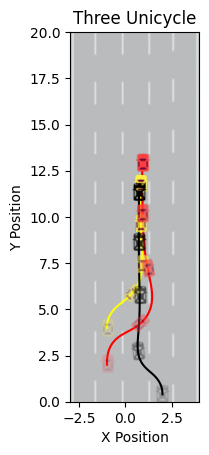

In [15]:
from MAGPS.data import Batch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.ndimage import rotate
import matplotlib.image as mpimg
import numpy as np

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V0(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old0(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

def evaluate_V1(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

initial_state_low = np.array([
    -3, -3, 0.1, np.pi/2, 
    0, 0, 0.1, np.pi/2, 
])

initial_state_high = np.array([
    0, 0, 1.9, np.pi/2, 
    3, 3, 1.9, 3/2*np.pi, 
])
horizon = 120
n = env.observation_space.shape[0]
m = env.action_space.shape[0]
x_traj = np.zeros((n, horizon+1))
u_traj = np.zeros((m, horizon))
x_traj[:,0] = np.array([
    -1,  4 ,1., np.pi/2,
    -1,  2, 1., np.pi/2,
    2.0, 0.4, 1., np.pi/2
])
envs.reset(options={"initial_state": x_traj[:,0]})
cost_traj = np.zeros((horizon,1))
for t in range(horizon):
    u_traj[:,t] = find_a(x_traj[:,t])
    x_traj[:,t+1] = envs.step(u_traj[:,t])[0]


# Load car images
car_img_1 = plt.imread("image/yellow_car.png")  # Replace with the path to your car image for agent 1
car_img_2 = plt.imread("image/red_car.png")  # Replace with the path to your car image for agent 2
car_img_3 = plt.imread("image/black_car.png")  # Replace with the path to your car image for agent 2

# Helper function to add rotated car images
def add_car_image(ax, x, y, image, heading=None, zoom=0.5, alpha=0.2):  # Add alpha as an argument
    # Rotate the image if heading is specified
    if heading is not None:
        rotated_image = rotate(image, angle=-heading, reshape=True)  # Rotate image, negative to match plot rotation
    else:
        rotated_image = image
    
    # Create an OffsetImage with the rotated image
    offset_image = OffsetImage(rotated_image, zoom=zoom, alpha=alpha)  # Set transparency with alpha
    
    # Add the image to the plot
    ab = AnnotationBbox(offset_image, (x, y), frameon=False)
    ax.add_artist(ab)

# Plot the trajectories
fig, ax = plt.subplots()
background = mpimg.imread("image/road.jpg")

# Display the background image with automatic aspect adjustment
ax.imshow(background, aspect="auto", extent=(-3, 4, 0, 20), cmap="gray", alpha=0.3)
ax.plot(x_traj[0, :], x_traj[1, :], label="Agent 1 Trajectory", color="yellow")
ax.plot(x_traj[4, :], x_traj[5, :], label="Agent 2 Trajectory", color="red")
ax.plot(x_traj[8, :], x_traj[9, :], label="Agent 3 Trajectory", color="black")

# Add car images for specific positions along the trajectory

add_car_image(ax, x_traj[0, 0], x_traj[1, 0], car_img_1, heading=np.rad2deg(-x_traj[3, 0]+np.pi/2), zoom=0.5,alpha=0.2)
add_car_image(ax, x_traj[4, 0], x_traj[5, 0], car_img_2, heading=np.rad2deg(-x_traj[7, 0]+np.pi/2), zoom=0.5,alpha=0.2)
add_car_image(ax, x_traj[8, 0], x_traj[9, 0], car_img_3, heading=np.rad2deg(-x_traj[11, 0]+np.pi/2), zoom=0.5,alpha=0.2)


add_car_image(ax, x_traj[0, 30], x_traj[1, 30], car_img_1, heading=np.rad2deg(-x_traj[3, 30]+np.pi/2), zoom=0.5,alpha=0.4)
add_car_image(ax, x_traj[4, 30], x_traj[5, 30], car_img_2, heading=np.rad2deg(-x_traj[7, 30]+np.pi/2), zoom=0.5,alpha=0.4)
add_car_image(ax, x_traj[8, 30], x_traj[9, 30], car_img_3, heading=np.rad2deg(-x_traj[11, 30]+np.pi/2), zoom=0.5,alpha=0.4)

add_car_image(ax, x_traj[0, 60], x_traj[1, 60], car_img_1, heading=np.rad2deg(-x_traj[3, 60]+np.pi/2), zoom=0.5,alpha=0.6)
add_car_image(ax, x_traj[4, 60], x_traj[5, 60], car_img_2, heading=np.rad2deg(-x_traj[7, 60]+np.pi/2), zoom=0.5,alpha=0.6)
add_car_image(ax, x_traj[8, 60], x_traj[9, 60], car_img_3, heading=np.rad2deg(-x_traj[11, 60]+np.pi/2), zoom=0.5,alpha=0.6)

add_car_image(ax, x_traj[0, 90], x_traj[1, 90], car_img_1, heading=np.rad2deg(-x_traj[3, 90]+np.pi/2), zoom=0.5,alpha=0.8)
add_car_image(ax, x_traj[4, 90], x_traj[5, 90], car_img_2, heading=np.rad2deg(-x_traj[7, 90]+np.pi/2), zoom=0.5,alpha=0.8)
add_car_image(ax, x_traj[8, 90], x_traj[9, 90], car_img_3, heading=np.rad2deg(-x_traj[11, 90]+np.pi/2), zoom=0.5,alpha=0.8)
# Add car images for the final positions
add_car_image(ax, x_traj[0, -1], x_traj[1, -1], car_img_1, heading=np.rad2deg(-x_traj[3, -1]+np.pi/2), zoom=0.5,alpha=1)
add_car_image(ax, x_traj[4, -1], x_traj[5, -1], car_img_2, heading=np.rad2deg(-x_traj[7, -1]+np.pi/2), zoom=0.5,alpha=1)
add_car_image(ax, x_traj[8, -1], x_traj[9, -1], car_img_3, heading=np.rad2deg(-x_traj[11, -1]+np.pi/2), zoom=0.5,alpha=1)

# Set aspect ratio
aspect_ratio = 1
ax.set_aspect(aspect_ratio)

# Customize the plot
# ax.set_title("Agent Trajectories with Car Images")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
plt.title('Three Unicycles')
plt.show()
